In [1]:
using BenchmarkTools
using LinearAlgebra
using Plots

include("parallelized_DLA.jl")

Main.DLA_parallel

---
# Parallel DLA implementation

## Prototype

### Step 1: Initialize constants

In [52]:
birth_radius = 38
num_walkers = 300
num_steps = 1000
desired_cluster_size = 10

# cluster = []
# sizehint!(cluster, desired_cluster_size+1)

# push!(cluster, [0,0])

10

In [108]:
for v in cluster
    print(v)
end

### Step 2: Generate the random walks where each starts at a random position on the birth circle

In [53]:
directions = [[1,0], [-1,0], [0,1], [0,-1]]
typeof(directions)

Vector{Vector{Int64}} (alias for Array{Array{Int64, 1}, 1})

In [54]:
# Generate W random walks of K steps each and choose the initial positions
# i-th column: i-th walker, j-th row: j-th step
random_walks = rand(directions, (num_steps+1, num_walkers))
random_walks[1, :] = rand(Utils.get_circle_points(birth_radius), num_walkers)

random_walks
;

In [55]:
# Cumulative sum gives the trajectories of each randomly walking particle
# i-th column: i-th walker, j-th row: j-th step
traverses = cumsum(random_walks, dims=1)
traverses
;

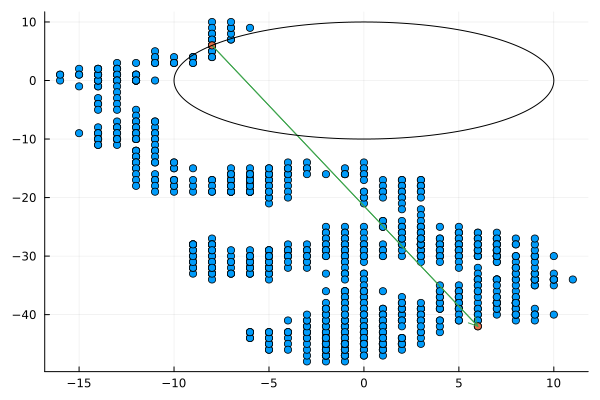

In [113]:
i = 1
traverse = traverses[:, i]

fig = plot()

# Plot all points visited
plot!(fig, ([v[1] for v in traverse], [v[2] for v in traverse]), seriestype=:scatter, label="")

# Plot first and last points
scatter!(fig, ([first(traverse)[1], last(traverse)[1]], [first(traverse)[2], last(traverse)[2]]), label="")

# Plot arrow between first and last point
quiver!(fig, ([first(traverse)[1]], [first(traverse)[2]]), 
        quiver=([(last(traverse) - first(traverse))[1]], [(last(traverse) - first(traverse))[2]]), label="")

# birth circle
r = birth_radius
θ = range(-π, π, 1000)
plot!(fig, (r * cos.(θ), r * sin.(θ)), color="black", label="")

fig

### Step 3: Post-processing

Brute force

In [ ]:
step_contact_time = ones(Int64, num_walkers) * -1

In [130]:
for (w, traverse) in enumerate(eachcol(traverses))
    for (k, step) in enumerate(traverse)
        print("walker $w at step $k:")
        println(step)
    end
end

In [ ]:
for walk in eachcol(traverses)
    println(walk)
end

In [12]:
println(cluster[1] + directions[1])
println((cluster[1] + directions[1]) == [1,0])

[1, 0]
true


In [13]:
try
    [0, 0] + directions
catch DimensionMismatch
    print("This doesn't work because a vector of vectors isn't a nx2 array to which we could easily broadcast operations.")
end

This doesn't work because a vector of vectors isn't a nx2 array to which we could easily broadcast operations.

In [17]:
# function is_adjacent(step, deposit)
#     directions = [[1, 0], [-1, 0], [0, 1], [0, -1]]
#     for direction in directions  # could be vectorized if deposit + direction worked!
#         if step == (deposit + direction)
#             return true
#         end
#     end
#     return false
# end

function is_adjacent(step, deposit)
    directions = [[1,0], [-1,0], [0,1], [0,-1]]
    if step in (directions .+ Ref(deposit))
        return true
    end
    return false
end


# function detect_contact_with_cluster(trajectory, cluster)
#     not_adjacent_to_cluster = true
#     for step in trajectory
#         for deposit in cluster
#             if is_adjacent(step, deposit)

#         end
#         if not_adjacent_to_cluster == false
#             break
#         end
#         # TODO: Implement death circle
#     end
#     return Nothing  # walker doesn't contact cluster
# end

is_adjacent (generic function with 1 method)

In [34]:
[[1,2], [1,3]] .- Ref([1,2])

2-element Vector{Vector{Int64}}:
 [0, 0]
 [0, 1]

In [35]:
is_adjacent([1,2], [1,1])

true

In [39]:
traverse = traverses[:, 1]

for (i, step) in enumerate(traverse)
    for (j, deposit) in enumerate(cluster)
        if is_adjacent(step, deposit)
            print(step, deposit)
        end
    end
end

[0, 1][0, 0]

In [40]:
not_adjacent_to_cluster = true

while not_adjacent_to_cluster

    for step in traverse

        if not_adjacent_to_cluster == false
            break
        end

        for deposit in cluster

            if is_adjacent(step, deposit)
                println(step, deposit)
                not_adjacent_to_cluster = false
                break
            end
        end
    end
    break  # occurs if none of the steps are adjacent to cluster
end

[0, 1][0, 0]


In [6]:
function is_step_adjacent_to_cluster(walker_step, cluster)
    directions = [[1,0], [-1,0], [0,1], [0,-1]]
    for deposit in cluster
        for direction in directions
            if walker_step == (deposit + direction)
                return true
            end
        end
    end
    return false
end

is_step_adjacent_to_cluster (generic function with 1 method)

In [7]:
is_step_adjacent_to_cluster([1,2], [[0,0], [1,0], [1,1]])
@benchmark is_step_adjacent_to_cluster($[1,2], $[[0,0], [1,0], [1,1]])

BenchmarkTools.Trial: 10000 samples with 181 evaluations.
 Range (min … max):  583.978 ns … 52.486 μs  ┊ GC (min … max): 0.00% … 93.42%
 Time  (median):     684.254 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.049 μs ±  1.626 μs  ┊ GC (mean ± σ):  7.27% ±  6.42%

  █▅▅▄▅▄▄▃▃▂▂▁▁                                                ▂
  █████████████████▆▆▇▆▆▆▆▅▅▅▅▆▅▅▅▅▅▅▄▄▅▅▅▁▄▃▄▃▄▁▃▄▅▄▄▄▄▄▅▄▁▅▄ █
  584 ns        Histogram: log(frequency) by time      6.97 μs <

 Memory estimate: 1.25 KiB, allocs estimate: 16.

In [56]:
# Initialize cluster by putting a seed at the origin
# cluster = []
# sizehint!(cluster, desired_cluster_size)
# push!(cluster, [0,0])


# Generate random walks
# pass


# One pass of the parallelized algorithm
for traverse in eachcol(traverses)
    for step in traverse
        if is_step_adjacent_to_cluster(step, cluster)
            push!(cluster, step)
            break
        end
    end
end

In [57]:
cluster

436-element Vector{Any}:
 [0, 0]
 [0, -1]
 [0, -2]
 [-1, -2]
 [1, -2]
 [-1, -1]
 [0, 1]
 [1, 0]
 [-1, -3]
 [-1, -4]
 ⋮
 [-26, 14]
 [-2, -40]
 [-22, -19]
 [4, -38]
 [-1, -33]
 [-6, -31]
 [-22, -10]
 [-15, 22]
 [-21, -8]

In [6]:
@time cluster = DLA_parallel.parallelized_DLA(100, 2000, 2000, 10)

 2031

2031-element Vector{Any}:
 [0, 0]
 [0, 1]
 [0, 2]
 [0, 3]
 [-1, 0]
 [1, 0]
 [0, 4]
 [-1, 1]
 [-2, 1]
 [-3, 1]
 [1, 1]
 [0, -1]
 [0, -2]
 ⋮
 [23, -35]
 [17, 36]
 [10, 42]
 [18, -38]
 [-6, 40]
 [38, 17]
 [-17, -37]
 [42, -3]
 [-42, 0]
 [35, -20]
 [-14, -40]
 [-4, -40]

208.987082 seconds (2.04 G allocations: 151.978 GiB, 9.89% gc time)


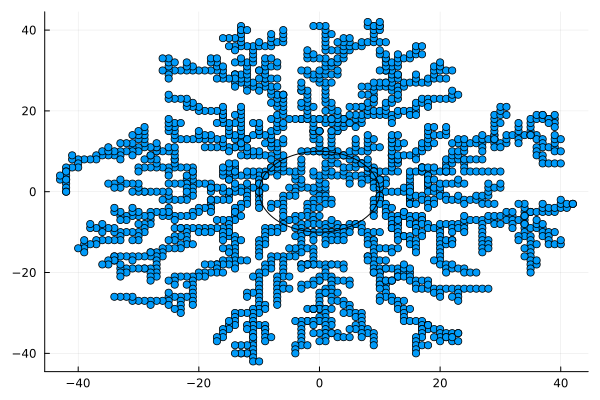

In [7]:
fig = scatter()
scatter!(fig, ([v[1] for v in cluster], [v[2] for v in cluster]), label="")

r = 10
θ = range(-π, π, 1000)
plot!(fig, (r * cos.(θ), r * sin.(θ)), color="black", label="")

In [67]:
abs2.([1,2])

2-element Vector{Int64}:
 1
 4

In [ ]:
norm

In [73]:
map(x -> norm(x), cluster)

436-element Vector{Float64}:
  0.0
  1.0
  2.0
  2.23606797749979
  2.23606797749979
  1.4142135623730951
  1.0
  1.0
  3.1622776601683795
  4.123105625617661
  ⋮
 29.5296461204668
 40.049968789001575
 29.068883707497267
 38.2099463490856
 33.015148038438355
 31.575306807693888
 24.166091947189145
 26.627053911388696
 22.47220505424423

---
# Appendix A: Circle generation

Demonstration

In [69]:
r = 16

# Discrete circle
circle_points = Utils.get_circle_points(r)

# Continuous circle
x_points = [x for x in range(-1*r, r, 1000)]
upper_circle_boundary = (r^2 .- x_points.^2).^0.5
lower_circle_boundary = (-1).*upper_circle_boundary
;

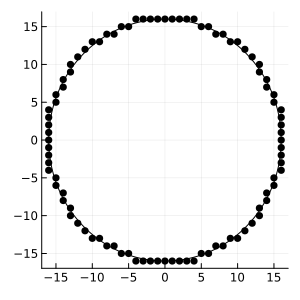

In [70]:
s = scatter(size=(300,300))
for (px, py) in circle_points
    scatter!(s, (px, py), color="black", label="")
end

plot!(s, (x_points, upper_circle_boundary), color = "black", label="")
plot!(s, (x_points, lower_circle_boundary), color = "black", label="")

Benchmarking

In [10]:
r = 1_000_000
@btime Utils.get_circle_points($r)
;

  26.707 ns (1 allocation: 16 bytes)
